### 1- Create an SQL query or queries to extract the information you think may be relevant for building the prediction model. It should include some film features and some rental features

In [1]:
'''
The mysql code creates a view 'rental_prediction' with relevant input variables and the target variable as column 'rental_satus' and is imported into a dataframe in the following step 

CREATE OR REPLACE VIEW sakila.rental_prediction AS
WITH cte_rentals_0602 AS (
	SELECT film_id, i.inventory_id,
	CONVERT(DATE_FORMAT(CONVERT(rental_date, DATE), '%m'), UNSIGNED) AS rental_month,
	CONVERT(DATE_FORMAT(CONVERT(rental_date, DATE), '%Y'), UNSIGNED) AS rental_year
	FROM rental r
	JOIN inventory i
	ON r.inventory_id = i.inventory_id
	HAVING rental_month = 02 and rental_year = 2006
    ),
cte_rentals_0602_aggr AS (
	SELECT film_id, COUNT(inventory_id) as rental_count, ROUND(AVG(rental_month)) AS rental_month, ROUND(AVG(rental_year)) AS rental_year
	FROM cte_rentals_0602
	GROUP BY film_id
    ),
cte_film_rentals_0602 AS (
	SELECT f.film_id, rental_count, rental_month, rental_year, rental_duration, rental_rate, length, rating
	FROM cte_rentals_0602_aggr cr
	RIGHT JOIN film f
	ON cr.film_id = f.film_id
    ),
cte_film_category AS (
	SELECT film_id, c.name as category
    FROM film_category fc
    JOIN category c
    ON fc.category_id = c.category_id
    )
SELECT cfr.film_id, rental_count, rental_duration, rental_rate, length, rating, category,
CASE 
	WHEN rental_month = 02 THEN 'TRUE'
    ELSE 'FALSE'
    END AS 'rental_status'
FROM cte_film_rentals_0602 cfr
JOIN cte_film_category cfc
ON cfr.film_id = cfc.film_id
ORDER BY cfr.film_id;
'''

"\nThe mysql code creates a view 'rental_prediction' with relevant input variables and the target variable as column 'rental_satus' and is imported into a dataframe in the following step \n\nCREATE OR REPLACE VIEW sakila.rental_prediction AS\nWITH cte_rentals_0602 AS (\n\tSELECT film_id, i.inventory_id,\n\tCONVERT(DATE_FORMAT(CONVERT(rental_date, DATE), '%m'), UNSIGNED) AS rental_month,\n\tCONVERT(DATE_FORMAT(CONVERT(rental_date, DATE), '%Y'), UNSIGNED) AS rental_year\n\tFROM rental r\n\tJOIN inventory i\n\tON r.inventory_id = i.inventory_id\n\tHAVING rental_month = 02 and rental_year = 2006\n    ),\ncte_rentals_0602_aggr AS (\n\tSELECT film_id, COUNT(inventory_id) as rental_count, ROUND(AVG(rental_month)) AS rental_month, ROUND(AVG(rental_year)) AS rental_year\n\tFROM cte_rentals_0602\n\tGROUP BY film_id\n    ),\ncte_film_rentals_0602 AS (\n\tSELECT f.film_id, rental_count, rental_month, rental_year, rental_duration, rental_rate, length, rating\n\tFROM cte_rentals_0602_aggr cr\n\tRIGH

### 2- Read the data into a Pandas dataframe

In [2]:
import pymysql
from sqlalchemy import create_engine
import getpass
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import norm
from scipy.special import inv_boxcox
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder, Normalizer, StandardScaler, LabelEncoder
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns
import os
import math
import random
import warnings
warnings.filterwarnings('ignore')
password = getpass.getpass()

pd.options.display.max_columns = None
pd.set_option('max_row', None)

 ········


In [33]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)
query = '''
        SELECT *
        FROM rental_prediction;
        '''

In [56]:
data = pd.read_sql_query(query, engine)

### 3- Analyze extracted features and transform them. You may need to encode some categorical variables, or scale numerical variables

#### | data overview |

In [57]:
data.head()

,film_id,rental_count,rental_duration,rental_rate,length,rating,category,rental_status
0,1,NaN,6,0.99,86,PG,Documentary,0
1,2,1.0,3,4.99,48,G,Horror,1
2,3,NaN,7,2.99,50,NC-17,Documentary,0
3,4,1.0,5,2.99,117,G,Horror,1
4,5,1.0,6,2.99,130,G,Family,1


In [58]:
data.shape

(1000, 8)

In [59]:
data.dtypes

film_id              int64
rental_count       float64
rental_duration      int64
rental_rate        float64
length               int64
rating              object
category            object
rental_status        int64
dtype: object

In [60]:
col_cat = list(data.select_dtypes(include=[np.object]).columns.values)

for column in col_cat:
    print(column, data[column].unique())

rating ['PG' 'G' 'NC-17' 'PG-13' 'R']
category ['Documentary' 'Horror' 'Family' 'Foreign' 'Comedy' 'Sports' 'Music'
 'Classics' 'Animation' 'Action' 'New' 'Sci-Fi' 'Drama' 'Travel' 'Games'
 'Children']


In [89]:
data['rental_status'].value_counts()

0    832
1    168
Name: rental_status, dtype: int64

> The target variable is highly skewed towards the value '0'/'False' which is going to reduced the performance of the model

#### | indexing |

In [61]:
data = data.set_index('film_id')
data.head()

,rental_count,rental_duration,rental_rate,length,rating,category,rental_status
film_id,,,,,,,
1,NaN,6,0.99,86,PG,Documentary,0
2,1.0,3,4.99,48,G,Horror,1
3,NaN,7,2.99,50,NC-17,Documentary,0
4,1.0,5,2.99,117,G,Horror,1
5,1.0,6,2.99,130,G,Family,1


#### | droping unneccesary columns |

In [62]:
data = data.drop(['rental_count'], axis=1)

#### | data cleaning |

In [63]:
def first_clean(df, columns=col_cat, skip_columns=[]):
    for column in columns:
        if column not in skip_columns:
            df[column] = df[column].str.strip().str.lower().str.replace(' ','_')
    return df

data = first_clean(data, skip_columns=['rating'])


#### | dealing with null values |

In [64]:
for column in data.columns:
    print(column, data[column].isna().sum())

rental_duration 0
rental_rate 0
length 0
rating 0
category 0
rental_status 0


#### | EDA |

In [65]:
data_m = data.copy()
data_cat = data_m.select_dtypes(np.object)
data_num = data_m.select_dtypes(np.number)

In [66]:
# overview numerical columns

data_num.describe().T

,count,mean,std,min,25%,50%,75%,max
rental_duration,1000.0,4.985,1.411654,3.00,4.00,5.00,6.00,7.00
rental_rate,1000.0,2.980,1.646393,0.99,0.99,2.99,4.99,4.99
length,1000.0,115.272,40.426332,46.00,80.00,114.00,149.25,185.00
rental_status,1000.0,0.168,0.374053,0.00,0.00,0.00,0.00,1.00


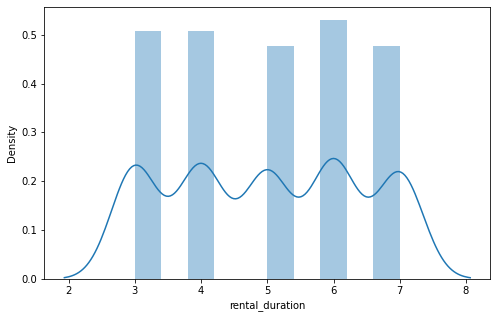

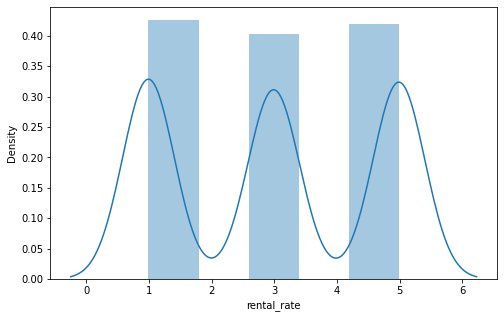

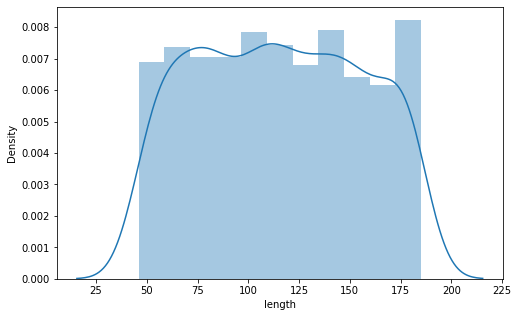

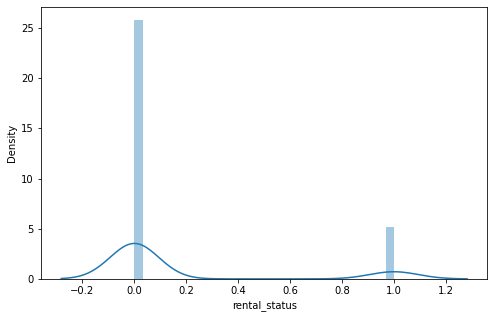

In [67]:
for column in data_num:
    plt.figure(figsize=(8,5))
    sns.distplot(data_num[column])
    plt.show()

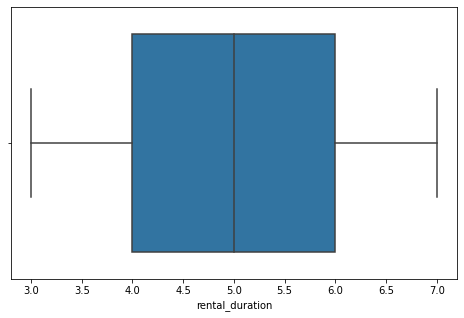

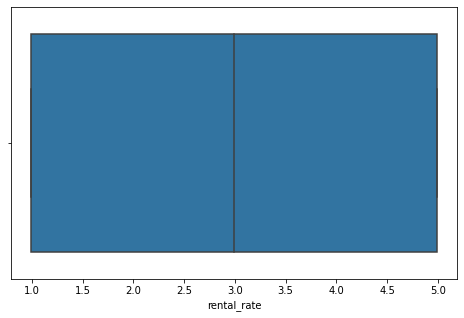

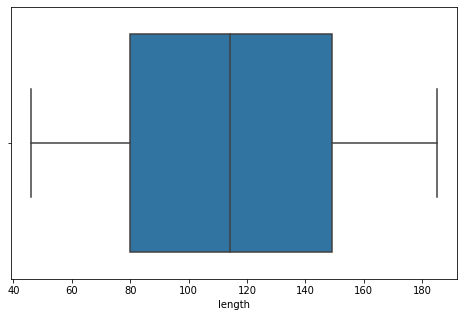

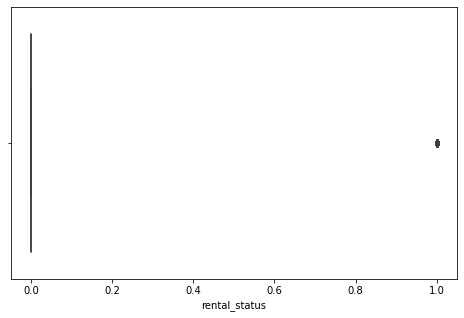

In [68]:
for column in data_num:
    plt.figure(figsize=(8,5))
    sns.boxplot(x=data_num[column])
    plt.show()

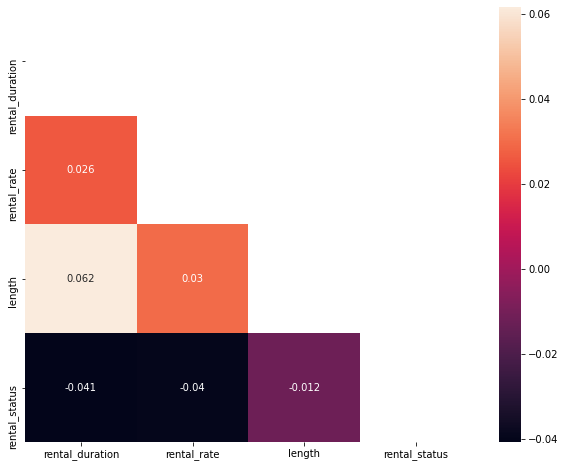

In [69]:
mask = np.zeros_like(data_num.corr())

mask[np.triu_indices_from(mask)] = True 

fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(data_num.corr(), mask=mask, annot=True)
plt.show()

#### | Transformations |

In [70]:
# encoding categorical columns

col_encode = ['rating', 'category']
data_m = pd.get_dummies(data_m, columns=col_encode, drop_first=True)


### 4- Create a query to get the list of films and a boolean indicating if it was rented last month. This would be our target variable

#### | Conversion of target variable |

In [71]:
data_m['rental_status'] = data_m['rental_status'].astype('bool')


#### | X-Y Split |

In [72]:
y = data_m['rental_status']
X = data_m.drop('rental_status', axis=1)

### 5- Create a logistic regression model to predict this variable from the cleaned data

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)

In [77]:
classification = LogisticRegression(random_state=11, multi_class='ovr', max_iter=500)
classification.fit(X_train, y_train)

LogisticRegression(max_iter=500, multi_class='ovr', random_state=11)

### 6- Evaluate the results (calculate the score of the model)

#### | Model score |

In [78]:
classification.score(X_test, y_test)

0.845

#### | Prediction evaluation |

In [79]:
predictions = classification.predict(X_test)

pd.Series(predictions).value_counts()

False    200
dtype: int64

In [80]:
y_test.value_counts()

False    169
True      31
Name: rental_status, dtype: int64

In [81]:
confusion_matrix(y_test, predictions)

array([[169,   0],
       [ 31,   0]])

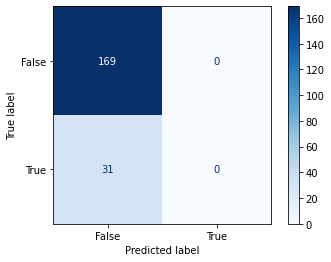

In [82]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(classification, X_test, y_test, cmap='Blues')
plt.show()

#### | Conclusion |

Despite a high score of 0.84, the model is not a very useful model for predictions, bescause it always predicts 'false'.